## IMPORT DATA

In [1]:
import pandas as pd 
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')



# EDA

In [2]:
#information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
for col in df_train.columns:
     print(col)
     print(df_train[col].isnull().sum())

id
0
keyword
61
location
2533
text
0
target
0


In [4]:
for col in df_test.columns:
     print(col)
     print(df_test[col].isnull().sum())

id
0
keyword
26
location
1105
text
0


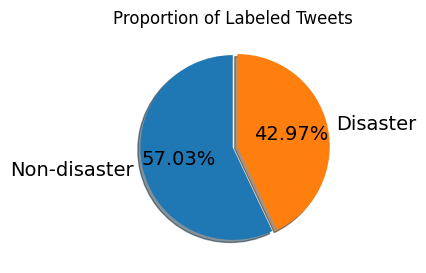

In [5]:
# generate a pie plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 3))
plt.pie(df_train['target'].value_counts(), explode=(0, 0.05), labels=["Non-disaster", "Disaster"],
        autopct="%0.2f%%", textprops={'fontsize': 14}, shadow=True, startangle=90)
plt.title('Proportion of Labeled Tweets')
plt.show()

target
0    4342
1    3271
Name: count, dtype: int64


<Axes: title={'center': 'Class Distribution'}, xlabel='target'>

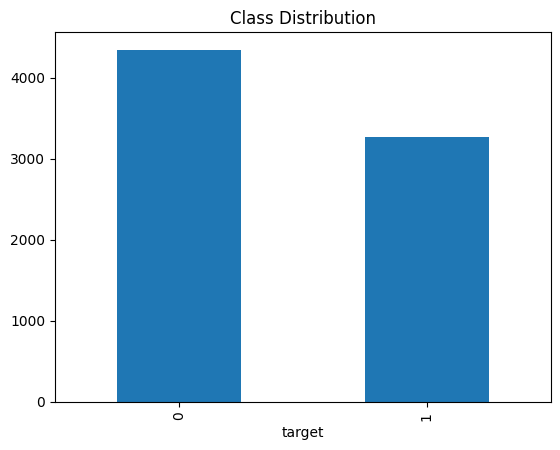

In [6]:
print(df_train['target'].value_counts())
df_train['target'].value_counts().plot(kind='bar', title='Class Distribution')

## Preprocessing

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import re 

stop_words = set(stopwords.words('english'))
wordnetlemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    sentences = sent_tokenize(text)
    processed_sentences = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        filtered_words = [wordnetlemmatizer.lemmatize(word) for word in words if word not in stop_words]
        processed_sentences.append(' '.join(filtered_words))
    
    return ' '.join(processed_sentences)




In [8]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
df_train['cleaned_text'] = df_train['text'].apply(preprocess)
df_test['cleaned_text'] = df_test['text'].apply(preprocess)

In [10]:
df_train.head(2)

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada


In [11]:
df_test.head(2)

,id,keyword,location,text,cleaned_text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...


#### TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_train['cleaned_text']).toarray()
y = df_train['target']

In [13]:
df_train.drop(columns=["keyword","location"],inplace=True)

In [14]:
df_test.drop(columns=["keyword","location"],inplace=True)


<Axes: title={'center': 'Text Length Distribution'}, ylabel='Frequency'>

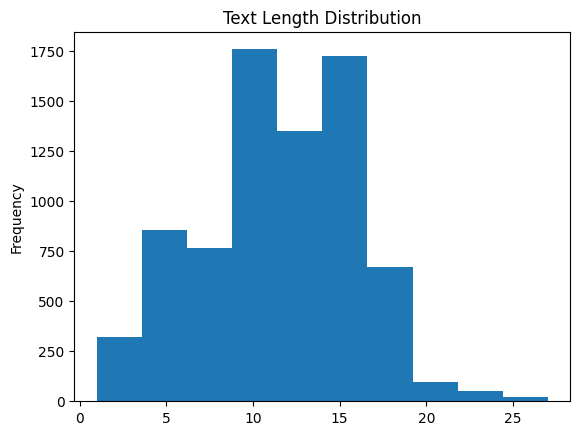

In [15]:
df_train['text_length'] = df_train['cleaned_text'].apply(lambda x: len(x.split()))
df_train['text_length'].plot(kind='hist', title='Text Length Distribution')

In [16]:
df_train.head()

,id,text,target,cleaned_text,text_length
0,1,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u,7
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,7
2,5,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...,11
3,6,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfire evacuation orde...,8
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...,9


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
model = LogisticRegression()
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print(f'Accuracy: {accuracy_score(y_test,y_test_pred)}')
print(f'Accuracy: {accuracy_score(y_train,y_train_pred)}')


Accuracy: 0.8108581436077058
Accuracy: 0.8722086695440046


## Word Embedding for training data

In [19]:
import spacy
import numpy as np
from gensim.models import Word2Vec

In [20]:
# Prepare data for Word2Vec (list of tokenized words per document)
tokenized_texts = df_train['cleaned_text'].apply(lambda x: x.split())
 
# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=2, workers=4)

# Check the vocabulary size
print(f"Vocabulary size: {len(w2v_model.wv)}")

Vocabulary size: 6151


In [21]:
def get_document_vector(words, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in words:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    return vector / count if count > 0 else vector

# Create feature matrix
df_train['w2v_features'] = tokenized_texts.apply(lambda x: get_document_vector(x, w2v_model))



In [22]:
X = np.vstack(df_train['w2v_features'].values)
y = df_train['target']

In [23]:
#Do the 'train-test' splitting with test size of 20% with random state of 2022 and stratify sampling too
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

## Model Creation & Evalution

#### logistic regression

In [24]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.84      0.70       874
           1       0.54      0.25      0.34       649

    accuracy                           0.59      1523
   macro avg       0.57      0.55      0.52      1523
weighted avg       0.57      0.59      0.55      1523



#### GradientBoosting

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75       874
           1       0.67      0.55      0.60       649

    accuracy                           0.69      1523
   macro avg       0.69      0.67      0.67      1523
weighted avg       0.69      0.69      0.69      1523



#### RandomForest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.81      0.76       874
           1       0.70      0.57      0.63       649

    accuracy                           0.71      1523
   macro avg       0.71      0.69      0.70      1523
weighted avg       0.71      0.71      0.71      1523



## To predict test.csv using word embedding

In [27]:
df_test.head()

,id,text,cleaned_text
0,0,Just happened a terrible car crash,happened terrible car crash
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


In [28]:
# Prepare data for Word2Vec (list of tokenized words per document)
tokenized_texts = df_test['cleaned_text'].apply(lambda x: x.split())
 
# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=2, workers=4)

# Check the vocabulary size
print(f"Vocabulary size: {len(w2v_model.wv)}")

Vocabulary size: 3613


In [29]:
def get_document_vector(words, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in words:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    return vector / count if count > 0 else vector

# Create feature matrix
df_test['w2v_features'] = tokenized_texts.apply(lambda x: get_document_vector(x, w2v_model))

In [30]:
df_test.head(2)

,id,text,cleaned_text,w2v_features
0,0,Just happened a terrible car crash,happened terrible car crash,"[-0.03943948011146858, 0.18873787578195333, 0...."
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,"[-0.024981269346816198, 0.11810840559857232, 0..."


In [31]:
X_test_w2v = np.vstack(df_test['w2v_features'].values)
print(X_test_w2v.shape) 

(3263, 100)


### Prediction using RondomForest

In [32]:
clf.fit(X,y)
y_pred = clf.predict(X_test_w2v)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [33]:
df_test.head(2)

,id,text,cleaned_text,w2v_features
0,0,Just happened a terrible car crash,happened terrible car crash,"[-0.03943948011146858, 0.18873787578195333, 0...."
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,"[-0.024981269346816198, 0.11810840559857232, 0..."


## Save file.csv

In [34]:
df_predictions = pd.DataFrame(y_pred, columns=['target'])


df_predictions = pd.concat([df_test['id'], df_predictions], axis=1)


df_predictions.to_csv('predictions.csv', index=False)